In [1]:
import pandas as pd
import os
from alchemlyb.parsing import amber
from alchemlyb.estimators import TI,MBAR
from alchemlyb.postprocessors.units import to_kcalmol, to_kJmol, to_kT


In [2]:
top = os.getcwd()
result_dir = ['complex_1_20_200_200', 'complex_7_20_200_200', 'complex_8_20_200_200']
os.chdir('./no_restraint_mix')
file_list = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [3]:
dHdl = pd.concat([amber.extract_dHdl(f'{top}/{dir}/vdw_crg_one_step/{filename}/ti001.out', T=300) for dir in result_dir for filename in file_list])
u_nk_rm_rest = pd.concat([amber.extract_u_nk(f'{top}/{dir}/vdw_crg_one_step/{filename}/ti001.out', T=300) for dir in result_dir for filename in file_list])

/home1/wsp/anaconda3/envs/alchemlyb/lib/python3.10/site-packages/alchemlyb/parsing/amber.py:39: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  index=pd.Float64Index(data_dic["time"], name='time'))
/home1/wsp/anaconda3/envs/alchemlyb/lib/python3.10/site-packages/alchemlyb/parsing/amber.py:39: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  index=pd.Float64Index(data_dic["time"], name='time'))
/home1/wsp/anaconda3/envs/alchemlyb/lib/python3.10/site-packages/alchemlyb/parsing/amber.py:39: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  index=pd.Float64Index(data_dic["time"], name='time'))
/home1/wsp/anaconda3/envs/alchemlyb/lib/python3.10/site-packages/alchemlyb/pars

In [4]:
u_nk_rm_rest.shape

(48000, 16)

In [5]:
u_nk_rm_rest

,,0.000,0.010,0.025,0.050,0.075,0.100,0.150,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,1.000
time,lambdas,,,,,,,,,,,,,,,,
151.0,0.0,0.0,3.879881,9.444401,18.138612,26.239294,33.863945,48.023297,61.119511,85.264211,107.716389,129.129750,149.834663,170.010819,189.762385,209.153442,228.225781
152.0,0.0,0.0,4.036889,9.865292,19.056887,27.704540,35.907247,51.268113,65.578929,92.085847,116.755644,140.239281,162.886314,184.898425,206.399313,227.469093,248.162310
153.0,0.0,0.0,3.992512,9.705011,18.604457,26.875306,34.647769,49.065090,62.394935,86.983794,109.871692,131.715524,152.843877,173.435218,193.593588,213.383730,232.848474
154.0,0.0,0.0,3.790464,9.184911,17.542896,25.286943,32.565720,46.124084,58.773772,82.473392,104.953737,126.725092,148.012800,168.925113,189.518178,209.823621,229.861006
155.0,0.0,0.0,3.998497,9.711666,18.604098,26.873228,34.660399,49.178275,62.715858,88.026610,111.970632,135.113552,157.711117,179.888253,201.710659,223.215752,244.426902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146.0,1.0,inf,333474.556187,80411.572633,26412.059715,13469.509498,8225.207060,3964.755017,2271.520510,937.603323,439.290564,210.910044,96.349118,37.811604,9.751729,-0.551675,0.000000
1147.0,1.0,inf,530273.175147,119192.542309,38013.952843,19129.749730,11581.319771,5523.778673,3148.831795,1302.091516,620.363407,308.686469,150.830142,67.761387,24.957461,5.414238,0.000000
1148.0,1.0,inf,459802.552227,104734.855448,33337.736078,16724.834668,10096.693122,4788.050302,2711.277263,1101.332812,511.018032,244.223703,111.738998,44.437365,12.137237,-0.018062,0.000000


In [6]:
ti_estimator = TI().fit(dHdl)
mbar_estimator = MBAR().fit(u_nk_rm_rest)

In [7]:
print('MBAR free energy output is\n', mbar_estimator.delta_f_)

print('energy unit is',  mbar_estimator.delta_f_.attrs['energy_unit'])
print('free energy difference is', mbar_estimator.delta_f_.loc[0.00, 1.00])

delta_f_kcalmol = to_kcalmol(mbar_estimator.delta_f_)
print('energy unit is', delta_f_kcalmol.attrs['energy_unit'])
print('free energy difference is now', delta_f_kcalmol.loc[0.00, 1.00])

MBAR free energy output is
            0.000      0.010      0.025      0.050      0.075      0.100  \
0.000   0.000000   3.620813   8.562046  15.778699  22.056602  27.663065   
0.010  -3.620813   0.000000   4.941233  12.157886  18.435789  24.042252   
0.025  -8.562046  -4.941233   0.000000   7.216652  13.494555  19.101019   
0.050 -15.778699 -12.157886  -7.216652   0.000000   6.277903  11.884366   
0.075 -22.056602 -18.435789 -13.494555  -6.277903   0.000000   5.606463   
0.100 -27.663065 -24.042252 -19.101019 -11.884366  -5.606463   0.000000   
0.150 -37.489564 -33.868751 -28.927517 -21.710865 -15.432962  -9.826499   
0.200 -46.024503 -42.403690 -37.462457 -30.245804 -23.967901 -18.361438   
0.300 -60.461023 -56.840210 -51.898976 -44.682324 -38.404421 -32.797957   
0.400 -72.576613 -68.955800 -64.014567 -56.797914 -50.520011 -44.913548   
0.500 -83.643000 -80.022187 -75.080954 -67.864301 -61.586398 -55.979935   
0.600 -91.047591 -87.426778 -82.485544 -75.268892 -68.990989 -63.384525 

In [8]:
delta_f = ti_estimator.delta_f_.iloc[0, -1]
d_delta_f = ti_estimator.d_delta_f_.iloc[0, -1]

In [9]:
print("TI:")
print("Free energy difference (TI)", delta_f, "kT")
print("Free energy difference (TI) error", d_delta_f, "kT")
print("Free energy difference (MBAR)", mbar_estimator.delta_f_.loc[0.0, 1.0], 'kT')
print("Free energy difference (MBAR) error", mbar_estimator.d_delta_f_.loc[0.0, 1.0], 'kT')


TI:
Free energy difference (TI) 92.36914411133303 kT
Free energy difference (TI) error 0.15725103311540642 kT
Free energy difference (MBAR) 92.98654782422182 kT
Free energy difference (MBAR) error 0.17199512435224062 kT


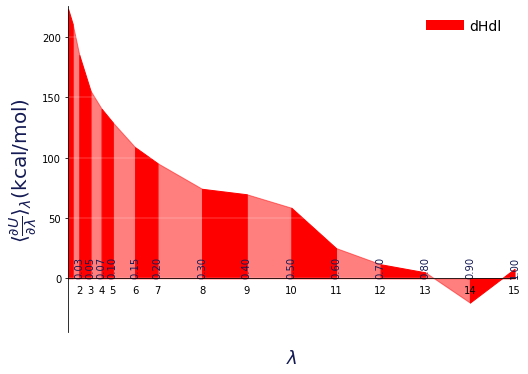

In [10]:
from alchemlyb.visualisation import plot_ti_dhdl,plot_mbar_overlap_matrix
ax = plot_ti_dhdl([ti_estimator], labels=['dHdl'], colors=['r'],units='kcal/mol')
ax.figure.savefig('onestep_dhdl_TI.pdf')

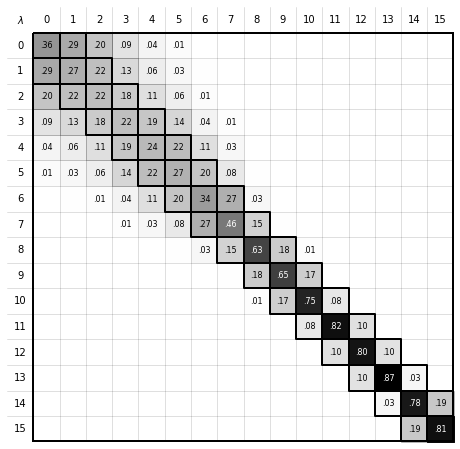

In [11]:
ax = plot_mbar_overlap_matrix(mbar_estimator.overlap_matrix)
ax.figure.savefig('onestep_MBAR.pdf', bbox_inches='tight', pad_inches=0.0)

In [12]:
import matplotlib.pyplot as plt
from alchemlyb.visualisation.dF_state import plot_dF_state

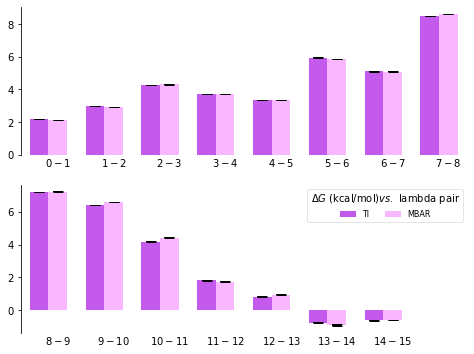

In [13]:
estimators = [(ti_estimator), (mbar_estimator)]

fig = plot_dF_state(estimators, orientation='portrait',units='kcal/mol')
fig.savefig('dF_state.pdf', bbox_inches='tight')

file_path = os.getcwd() + '/resust.txt'
with open(file_path,'w') as f:
    f.write(f'Free energy difference(TI): {delta_f * 0.596:.3f} ± {d_delta_f * 0.596:.3f} Kcal/mol\n') 
    f.write(f"Free energy difference (MBAR): {(mbar_estimator.delta_f_.loc[0.0, 1.0] * 0.596):.3f} ± {(mbar_estimator.d_delta_f_.loc[0.0, 1.0] * 0.596):.3f} Kcal/mol\n")
    for i in range(len(file_list)-1):
        f.writelines(f'{mbar_estimator.delta_f_.loc[file_list[i],file_list[i+1]] * 0.596:.3f}\n')

f.close()